In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image, make_grid
import os
import matplotlib.pyplot as plt
import gdown

In [2]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"suzaankhanc","key":"fdd48d81b469eac9230bde6654b62940"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d "Suzaan Khan C" "andrewmvd/animal-faces"

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 695M/696M [00:07<00:00, 28.7MB/s]
100% 696M/696M [00:07<00:00, 102MB/s] 


In [6]:
!unzip animal-faces.zip  # replace with file name downloaded

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [7]:
os.makedirs('cat_gan_results', exist_ok=True)

In [11]:
# Data Loading
def create_cat_dataloader(batch_size=64, image_size=64):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Only load cat images from the train folder
    dataset = ImageFolder(root='afhq/train', transform=transform)
    # Filter to keep only cat images (assuming cats are index 0)
    dataset.samples = [s for s in dataset.samples if s[1] == 0]
    dataset.targets = [0] * len(dataset.samples)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    print(f"Total number of cat images: {len(dataset)}")
    return dataloader

In [12]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        # 128x128 output images
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [13]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
      x = self.main(x)
      return x.view(x.size(0), -1)
        # return self.main(x)

In [14]:
# Training function with progress visualization
def train_cat_gan(dataloader, num_epochs=100, latent_dim=100, save_interval=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize networks
    netG = Generator(latent_dim).to(device)
    netD = Discriminator().to(device)

    # Optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

    # Lists to store losses for plotting
    G_losses = []
    D_losses = []

    print("Starting training...")
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Train Discriminator
            netD.zero_grad()
            # label_real = torch.ones(batch_size, 1, 1, 1, device=device)
            # label_fake = torch.zeros(batch_size, 1, 1, 1, device=device)
            label_real = torch.ones(batch_size, 1, device=device)
            label_fake = torch.zeros(batch_size, 1, device=device)

            output_real = netD(real_images)
            d_loss_real = criterion(output_real, label_real)

            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = netG(noise)
            output_fake = netD(fake_images.detach())
            d_loss_fake = criterion(output_fake, label_fake)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizerD.step()

            # Train Generator
            netG.zero_grad()
            output_fake = netD(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            optimizerG.step()

            # Save losses for plotting
            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')

        # Save generated images periodically
        if (epoch + 1) % save_interval == 0:
            with torch.no_grad():
                fake_images = netG(fixed_noise)
                save_image(fake_images,
                          f'cat_gan_results/fake_cats_epoch_{epoch+1}.png',
                          normalize=True, nrow=8)

            # Save models
            torch.save(netG.state_dict(),
                      f'cat_gan_results/generator_epoch_{epoch+1}.pth')
            torch.save(netD.state_dict(),
                      f'cat_gan_results/discriminator_epoch_{epoch+1}.pth')

            # Plot and save loss curves
            plt.figure(figsize=(10,5))
            plt.title("Generator and Discriminator Loss During Training")
            plt.plot(G_losses, label="Generator")
            plt.plot(D_losses, label="Discriminator")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.savefig(f'cat_gan_results/loss_plot_epoch_{epoch+1}.png')
            plt.close()

    return netG, netD, G_losses, D_losses

In [15]:
# Main training loop
def main():
    # Parameters
    batch_size = 64
    image_size = 64
    num_epochs = 120
    latent_dim = 100

    # Create dataloader for cats only
    dataloader = create_cat_dataloader(batch_size, image_size)
    print(f"Number of batches: {len(dataloader)}")

    # Train the GAN
    generator, discriminator, G_losses, D_losses = train_cat_gan(
        dataloader,
        num_epochs=num_epochs,
        latent_dim=latent_dim
    )

In [16]:
main()

Total number of cat images: 5153
Number of batches: 81
Using device: cuda
Starting training...
Epoch [0/120] Batch [0/81] D_loss: 1.4371 G_loss: 2.7410
Epoch [1/120] Batch [0/81] D_loss: 0.5587 G_loss: 9.4468
Epoch [2/120] Batch [0/81] D_loss: 0.5118 G_loss: 2.5875
Epoch [3/120] Batch [0/81] D_loss: 0.7215 G_loss: 3.0251
Epoch [4/120] Batch [0/81] D_loss: 0.5956 G_loss: 3.9604
Epoch [5/120] Batch [0/81] D_loss: 0.5225 G_loss: 3.8143
Epoch [6/120] Batch [0/81] D_loss: 0.9395 G_loss: 6.3038
Epoch [7/120] Batch [0/81] D_loss: 0.7570 G_loss: 5.5944
Epoch [8/120] Batch [0/81] D_loss: 1.1125 G_loss: 6.1823
Epoch [9/120] Batch [0/81] D_loss: 0.7558 G_loss: 2.5883
Epoch [10/120] Batch [0/81] D_loss: 0.5710 G_loss: 3.7337
Epoch [11/120] Batch [0/81] D_loss: 0.7595 G_loss: 2.0375
Epoch [12/120] Batch [0/81] D_loss: 0.9962 G_loss: 6.2385
Epoch [13/120] Batch [0/81] D_loss: 0.5118 G_loss: 2.8351
Epoch [14/120] Batch [0/81] D_loss: 0.4182 G_loss: 4.2195
Epoch [15/120] Batch [0/81] D_loss: 0.8238 G_

<ipython-input-39-aa683986134b>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


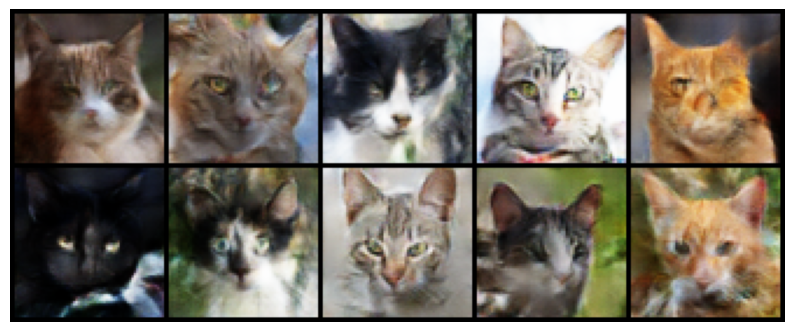

In [39]:
import torch
from torchvision.utils import save_image, make_grid
from torch import nn
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Load the trained model
def load_trained_generator(model_path, latent_dim=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Generator(latent_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model, device

# Generate multiple images and plot them
def generate_and_plot_images(generator, device, latent_dim=100, num_images=10):
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(noise)

    fake_images = (fake_images + 1) / 2  # Normalize from [-1,1] to [0,1]
    grid_img = make_grid(fake_images, nrow=5, padding=2, normalize=True)

    # Convert the tensor to numpy for plotting
    np_grid_img = grid_img.cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid_img)
    plt.axis("off")
    plt.show()

# Main function to generate and plot images
def main():
    model_path = "/content/cat_gan_results/generator_epoch_120.pth"
    generator, device = load_trained_generator(model_path)
    generate_and_plot_images(generator, device)

if __name__ == "__main__":
    main()
